In [ ]:
!pip install tensorflow tensorflow-datasets matplotlib --quiet

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(ds_train, ds_val), ds_info = tfds.load(
    "plant_village",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
CLASS_NAMES = ds_info.features["label"].names

print("Number of classes:", NUM_CLASSES)
print("Example classes:", CLASS_NAMES[:5])

Number of classes: 38
Example classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [ ]:
train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # freeze pretrained layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
 n

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2078s 2s/step - accuracy: 0.8155 - loss: 0.6880 - val_accuracy: 0.9372 - val_loss: 0.1948
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2124s 2s/step - accuracy: 0.9485 - loss: 0.1555 - val_accuracy: 0.9512 - val_loss: 0.1482
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2129s 2s/step - accuracy: 0.9634 - loss: 0.1124 - val_accuracy: 0.9409 - val_loss: 0.1778
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2045s 2s/step - accuracy: 0.9677 - loss: 0.0928 - val_accuracy: 0.9430 - val_loss: 0.1701
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2052s 2s/step - accuracy: 0.9760 - loss: 0.0716 - val_accuracy: 0.9495 - val_loss: 0.1693
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2031s 1s/step - accuracy: 0.9789 - loss: 0.0618 - val_accuracy: 0.9511 - val_loss: 0.1646
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1957s 1s/step - accuracy: 0.9838 - loss: 0.0463 - val_accuracy: 0.9557 - val_loss: 0.1557
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1932s 1s/step - accuracy: 0.9852 -

In [ ]:
model.save("plant_disease_tfds_model.h5")
print("✅ Model saved")

✅ Model saved


In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving plant4.png to plant4 (1).png


In [ ]:
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

predicted_class = CLASS_NAMES[np.argmax(predictions)]
confidence = np.max(predictions) * 100

print("🌱 Predicted Disease:", predicted_class)
print("📊 Confidence:", round(confidence, 2), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
🌱 Predicted Disease: Squash___Powdery_mildew
📊 Confidence: 99.98 %


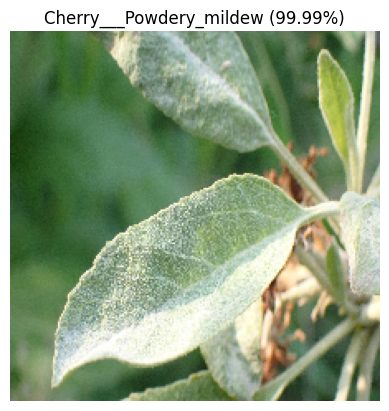

In [ ]:
plt.imshow(img)
plt.axis("off")
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.show()
